# Exploratory Data Analysis

**Highlights**

- Outliers were detected using two criteria (1) *false trips* criteria for short trips (trips with less than 1 minute duration) which is about 1.3% of the data and (2) *IQR* interquartile range for long trips (trips over 1.5 IQR from the middle 50%).
- The top 10 origin and destination stations were found. These 10 stations out of 266 (3.6%) account for the 13% and 14% of all trips, respectively. To create a first modeling approach, we will only analyze bike supply and demand for the top station, which is **Union Station**, accounting for a 2% and 2.6% as origin and destination, respectively.
- During 2017, 63.102 bikes were taken from and to Union Station in total. Considering the 5.000 bikes available today, and Union Station's average of 172 bikes a day, with a maximum of nearly 500 bikes, *up to 10% of all bikes could be used at specific hours* at this station alone. Furthermore, this mean goes up to 213 bikes during weekdays, which means trips are mainly skewed towards weekdays instead of weekends.
- 


In [2]:
# Basics
import pandas as pd
import numpy as np
import math
from datetime import datetime

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Loading the data 

In [3]:
#Import the data
bike_df = pd.read_csv('../data/bts_clean.csv', parse_dates=['trip_start_time_f', 'trip_stop_time_f'])

## Outliers detection

Let's begin with the `trip_duration` variable which seems to have some outliers given the previous statistics explored


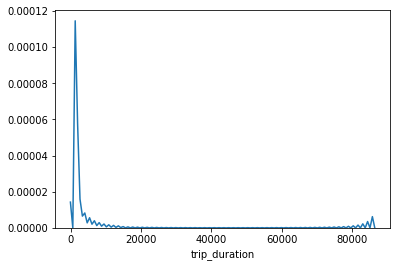

In [4]:
sns.distplot(bike_df.trip_duration, hist=False)

### Remove false trips

**Toronto Parking Authority (TPA)** generally considers trips less than a minute to be *false trips* in their own analysis, hence we are going to remove these from our data.

In [5]:
#Calculate the percentage of false trips
bike_df[bike_df.trip_duration < 60].shape[0]/bike_df.shape[0]

0.013096799323931816

This is about 1.3% of the data to be deleted.


In [6]:
#Drop the false trips
bike_df = bike_df[bike_df.trip_duration > 60]

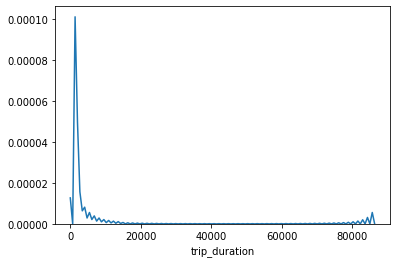

In [7]:
#Now plot the new distribution of trips
sns.distplot(bike_df.trip_duration, hist=False)

### Long trips

The outliers could be defined as data points that are $±1.5 IQR$ (Inter Quartile Range) away from the middle 50% of the data. Some of the outliers will be removed using this criteria:

In [8]:
# Get 25th and 75th quantile
q1 = bike_df.trip_duration.quantile(0.25)
q3 = bike_df.trip_duration.quantile(0.75)

# Calculate IQR
IQR = q3 - q1

#Get the percentage of data within this category
bike_df[((bike_df.trip_duration < (q1 - 1.5 * IQR)) | \
                                     (bike_df.trip_duration > (q3 + 1.5 * IQR)))] \
.reset_index(drop=True).shape[0]/bike_df.shape[0]

0.055536042885634636

According to this criteria, outliers represent about 5.6% of the dataset. This data will be removed since we are interested in modeling an "usual" service of the system.

In [9]:
#Filtering out outliers
bike_df = bike_df[~((bike_df.trip_duration < (q1 - 1.5 * IQR)) | \
                    (bike_df.trip_duration > (q3 + 1.5 * IQR)))].reset_index(drop=True)

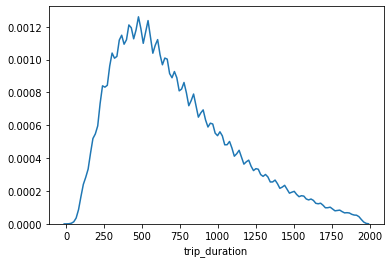

In [10]:
#Plot new distribution
sns.distplot(bike_df.trip_duration, hist=False)

Now we have a better distribution of the `trip_duration` variable to work with less extreme values.

## Narowing down the problem

In order to narrow down the analysis and test modeling approaches, we will start analyzing popular start and stop stations and how these two numbers match.

In [12]:
#Top 5 start stations (sorted by origin counts)
pd.DataFrame({'start_counts':bike_df.st_name_orig.value_counts(),
              'stop_counts': bike_df.st_name_dest.value_counts(),
             'start_pct': bike_df.st_name_orig.value_counts()/sum(bike_df.st_name_orig.value_counts())*100,
             'stop_pct': bike_df.st_name_dest.value_counts()/sum(bike_df.st_name_dest.value_counts())*100})\
.sort_values(by='start_counts', ascending=False).head(5).round(2)

,start_counts,stop_counts,start_pct,stop_pct
Union Station,27766,35604,2.02,2.60
Simcoe St / Wellington St South,20196,21613,1.47,1.58
Bathurst St / Dundas St W,18645,18376,1.36,1.34
Dundas St W / Yonge St,18206,19760,1.33,1.44
Bay St / Wellesley St W,17469,11278,1.27,0.82


In [13]:
#Top 5 stop stations (sorted by destination counts)
pd.DataFrame({'start_counts':bike_df.st_name_orig.value_counts(),
              'stop_counts': bike_df.st_name_dest.value_counts(),
             'start_pct': bike_df.st_name_orig.value_counts()/sum(bike_df.st_name_orig.value_counts())*100,
             'stop_pct': bike_df.st_name_dest.value_counts()/sum(bike_df.st_name_dest.value_counts())*100})\
.sort_values(by='stop_counts', ascending=False).head(5).round(2)

,start_counts,stop_counts,start_pct,stop_pct
Union Station,27766,35604,2.02,2.60
Simcoe St / Wellington St South,20196,21613,1.47,1.58
Dundas St W / Yonge St,18206,19760,1.33,1.44
Princess St / Adelaide St E,15905,18826,1.16,1.37
King St W / Spadina Ave,16944,18435,1.24,1.34


For the start and stop stations, the top 10 stations of 266 (3.6%) account for the 13% and 14% of all trips, respectively. To create a first modeling approach, we will only analyze supply and demand for the top station, which is **Union Station**, accounting for a 2% and 2.6% as origin and stop station, respectively.

### Extracting Union ridership

With this data, let's slice the rows containing Union Station as origin or destination.

In [14]:
bike_union = bike_df[(bike_df.st_name_orig == 'Union Station') | (bike_df.st_name_dest == 'Union Station')]
bike_union.shape

(63102, 15)

We have that during 2017, 63.102 bikes were taken from and to Union Station. Given that the systems uses about 5.000 bikes according to their website, it's critical to know how much of these bikes are being used at this station. However, that is the number of bikes today, we could think that as stations were nearly half of what they are today, the amount of bikes available could have been much less at that point in time.

Let's evaluate some statistics for this data:

In [15]:
#Summary of the amount of trips per day of the year
bike_union.groupby(bike_union.trip_start_time_f.dt.dayofyear).aggregate({'trip_id':'count'}).describe().T

,count,mean,std,min,25%,50%,75%,max
trip_id,365.0,172.882192,113.074126,2.0,81.0,141.0,267.0,499.0


With this statistics we can evidence that even considering the 5.000 bikes, Union Station uses on average 172 bikes a day, with a maximum of nearly 500 bikes! Almost 10% of all bikes available today! Let's see how these numbers are distributed for **busines days**.

In [16]:
# Count trips per weekday of the year
bike_union[~bike_union.trip_start_time_f.dt.weekday_name.isin(['Sunday', 'Saturday'])].\
groupby(bike_union.trip_start_time_f.dt.dayofyear).\
aggregate({'trip_id':'count'}).describe().T

,count,mean,std,min,25%,50%,75%,max
trip_id,260.0,213.342308,106.808538,2.0,116.75,221.0,300.5,499.0


As we see, the mean goes up to 213 bikes during weekdays, which means trips are mainly skewed towards weekdays.


## Approximating the station status variable

The 2017 ridership data should be used as raw material to create a model that helps us predict the necesary replenishment of the BTS stations on an hourly basis. For this, a time series of `station_status` data could be useful, but since that information is not at hand, we will use a **surrogate** variable: the **rate of change** of bikes inventory. Since we have the amount of bikes arriving and leaving the stations, and we have the stations' capacity, we could create a new variable that helps us assess how the inventory is changing with time so as to move bikes around the city from loaded stations to empty stations in an efficient manner.

### Creating dataset for stations

Now that we have narrowed down our search, it's time to create the dataset that will help us build our model. Let's first review what would be our ideal dataset:

**Ideal dataset fields**: timestamp, station name, station ID, number of bikes at the station

Since we don’t have the static variable that we want to predict, namely the number of bikes at every time at each station, we calculate a **rate of change** of this value, assuming known initial conditions. This variable will approximate the inflow and outflow of bikes for Union Station during each day hour of every day of the year.

**Derived dataset fields:** month, day, hour, station name, station ID, count of bikes arriving, count of bikes leaving

We will first extract the day of the year, month, day of the week and hour in which every event happened.


In [21]:
# Add new fields to dataframe
bike_union['dayofyear'] = bike_union.trip_start_time_f.dt.dayofyear
bike_union['weekday'] = bike_union.trip_start_time_f.dt.weekday
bike_union['hour'] = bike_union.trip_start_time_f.dt.hour

Now let's reshape the dataframe to obtain trip counts by weekday, hour and day of the year for trips going in and out of Union Station, for this we do the following

In [22]:
# Separating the dataframe into origin and destination registers
bike_union_orig = bike_union[bike_union.st_name_orig == 'Union Station']
bike_union_dest = bike_union[bike_union.st_name_dest == 'Union Station']

#Melting and the merging by days to get count of trips in and out of the station every hour
counts_union = pd.merge(bike_union_orig.groupby(['dayofyear','weekday','hour']).aggregate({'trip_id':'count'}).reset_index(),
                        bike_union_dest.groupby(['dayofyear','weekday','hour']).aggregate({'trip_id':'count'}).reset_index(),
                        how='outer',
                        left_on = ['dayofyear', 'weekday', 'hour'],
                        right_on = ['dayofyear', 'weekday', 'hour'],
                        suffixes=('_orig','_dest'), sort = True)

counts_union.head()

,dayofyear,weekday,hour,trip_id_orig,trip_id_dest
0,1,6,0,NaN,2.0
1,1,6,1,1.0,NaN
2,1,6,2,2.0,NaN
3,1,6,3,1.0,NaN
4,1,6,4,NaN,1.0


Here we have it, for every day of the year we have the weekday number, the hour of the day and the amount of trips with Union as origin and Union as destination. Let's do some further processing to tidy up the data.

In [23]:
#Change the column names
counts_union.columns = ['dayofyear', 'weekday', 'hour', 'count_trips_orig', 'count_trips_dest']

#Fill NAs in counts_union
counts_union.fillna(value=0, inplace=True)

#Modify so all time variables start at 0
counts_union.dayofyear = counts_union.dayofyear - 1

#Preview
counts_union.head()

,dayofyear,weekday,hour,count_trips_orig,count_trips_dest
0,0,6,0,0.0,2.0
1,0,6,1,1.0,0.0
2,0,6,2,2.0,0.0
3,0,6,3,1.0,0.0
4,0,6,4,0.0,1.0


## Exploring the rate of change

Now let's create our target variable, which is defined as the hourly rate of change of bikes stock, that is to say how many bikes are taken out vs how many bikes are taken to this station. This variable will be formulated as the substraction between `count_trips_orig` - `count_trips_dest`.

* When the rate of change is positive, we will have more bikes taken from the station (stock deficit)
* When the rate of change is negative, we will have more bikes are arriving to the station (stock surplus).


In [24]:
#Create new variable
counts_union['rate_of_change'] = counts_union.count_trips_orig - counts_union.count_trips_dest

In [25]:
#Get statistics for all days
counts_union.rate_of_change.describe().round(1)

count    6673.0
mean       -1.2
std         6.3
min       -45.0
25%        -2.0
50%        -1.0
75%         1.0
max        26.0
Name: rate_of_change, dtype: float64

In [26]:
#Get statistics for the business days
counts_union[counts_union.weekday.isin([1,2,3,4,5])].rate_of_change.describe().round(1)

count    4812.0
mean       -1.4
std         6.7
min       -45.0
25%        -3.0
50%        -1.0
75%         1.0
max        26.0
Name: rate_of_change, dtype: float64

From this we can get some interesting facts:

* The overall mean value of the rate of change is negative, which means that on average 1.2 bikes are added the bike stock every hour, and this number increases to 1.4 during business days. We could conclude that for this station we will not require bike replenishment on average, on the contrary, bikes will need to be removed from the station to free capacity for incoming riders.

* The maximum and minimum points are significantly high and would imply an arrival of bikes greater than the capacity of the station, which is 26 bikes and maybe the capacity of one replenishment truck. It is quite important to identify the hours of the day in which that happens so as to be prepared.

Now let's check the distribution of this variable

Text(0.5, 1.0, 'Distribution of the hourly rate of change')

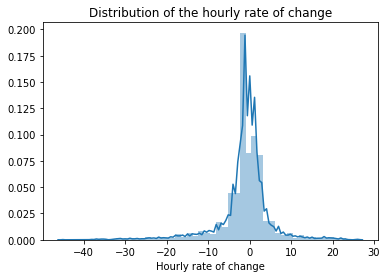

In [27]:
ax = sns.distplot(counts_union.rate_of_change)

ax.set_xlabel('Hourly rate of change')
ax.set_title('Distribution of the hourly rate of change')

The variable seems to follow a normal-like distribution with a mean close to zero, however, the values to the left are up to two times the capacity of the station. These are critical hours that must be evaluated. Now let's see the behavior of the rate of change for all days of the week.

Text(0, 0.5, 'Mean hourly rate of change')

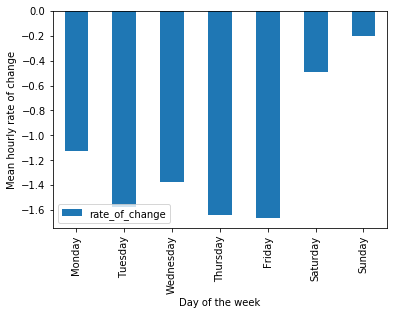

In [28]:
ax = counts_union.groupby('weekday').aggregate({'rate_of_change': 'mean'}).plot(kind='bar')

ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel('Day of the week')
ax.set_ylabel('Mean hourly rate of change')

Here we can see that for this specific station everyday we have a bike surplus every day of the week, however, for weekends this surplus is almost negligible and the suply/demand is almost balanced. Now lets get more granual, by looking at hourly averages:

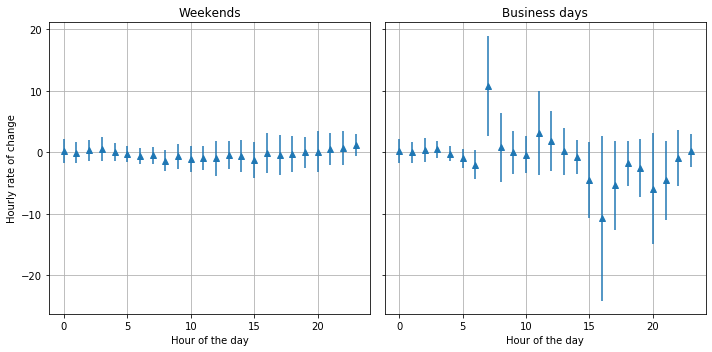

In [29]:
fig, axarr = plt.subplots(nrows = 1, ncols=2, figsize=(10,5), sharey=True)

df1 = counts_union[counts_union.weekday.isin([6,7])].groupby('hour').aggregate({'rate_of_change': ['mean', 'std']})
df2 = counts_union[~counts_union.weekday.isin([6,7])].groupby('hour').aggregate({'rate_of_change': ['mean', 'std']})

plt.sca(axarr[0])
plt.errorbar(df1.index, df1.rate_of_change['mean'], df1.rate_of_change['std'], 
             linestyle='None', marker='^')

axarr[0].set_title('Weekends')
axarr[0].set_xlabel('Hour of the day')
axarr[0].set_ylabel('Hourly rate of change')
plt.grid()

plt.sca(axarr[1])
plt.errorbar(df2.index, df2.rate_of_change['mean'], df2.rate_of_change['std'], 
             linestyle='None', marker='^')
axarr[1].set_title('Business days')
axarr[1].set_xlabel('Hour of the day')
plt.grid()
plt.tight_layout()


Here, we can extract a few insights:

* **During weekends we see a steady rate of change around zero**, this insight is important because it will mean that on average, we will not need people replenishing or taking bikes out of Union Station (here we could have some savings in resources).

* During the morning we tend to have a positive rate of change on average, and until 6 AM we have a balanced rate of change, also, we notice that for a peak demand at 7 AM the capacity of the station will satisfy the demand of about 10 bikes on average, hence the capacity is optimal for inflow of bikes during morning hours and we might not need to replenish bikes at Union Station.

* During afternoon we have the opposite, with **negative rates of change from 3 PM until 10 PM**. We will need to remove a significant amount of bikes during afternoon hours, even more during peak inflow hours (from 2 to 6) the capacity of the station will be exceeded users might arrive without anywhere to park their bikes, this might lead users to incur in overage affecting the service and even the probability of churn.

* One significant insight is the fact that on average, the mean and standard deviations will be within the capacity of the station, which seems to be optimal for the rate of change in general.


**Extreme values**

Let's dig deeper into where are these ouliers happenning. We are going to highlight the hours in which the rate of change is grater than the capacity of the station, given the fact that these peaks will create significant operational challenges.

In [30]:
#Extract those from the dataset
peaks = counts_union[(counts_union.rate_of_change > 26) | (counts_union.rate_of_change < -26)]

In [31]:
# Count those hours
peaks.shape[0]

65

Text(0.5, 0, 'Rate of change')

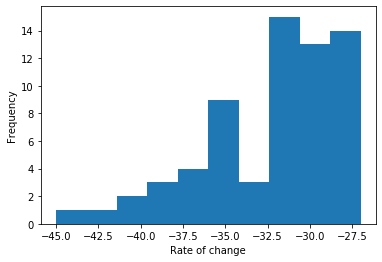

In [32]:
# How are distributed
peaks.rate_of_change.plot(kind='hist')
plt.xlabel('Rate of change')

So we have 65 hours in which we will have inflow of bikes (negative rate of change), let's check at how these are distributed throughout the hours of the day, days of the week and days of the year.

Text(0.5, 1.0, 'Count of peaks')

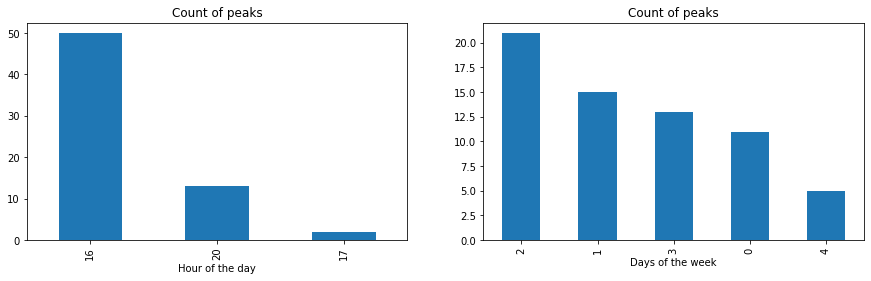

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

#Check distribution during the hours of the day
peaks.hour.value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_xlabel('Hour of the day')
ax[0].set_title('Count of peaks')

#Check distribution during the week
peaks.weekday.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Days of the week')
ax[1].set_title('Count of peaks')

In [34]:
#Check distribution during the year
peaks.dayofyear.value_counts().describe()

count    64.000000
mean      1.015625
std       0.125000
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: dayofyear, dtype: float64

Some observations regarding this graphs:

* We see that these peaks are mostly at 4 PM (busy hour for commuting), which is consistent with the data previously reviewed. At this time of the day, a large number of bikes are taken to this station for the "ride back home". However, it's interesting that the "ride to work" is not symmetric to this number. This station is used for getting home from work but not as much for getting to work.
* Almost every day of the week at 4 PM we will have an overflow of bikes at this station, however, at 5 PM and 8 PM is quite rare.
* Wednesday is the day that presents the most peaks for rate of change, followed in simmilar proportion by Tuesday, Thursday and Monday. On a Friday is rare to have a bike overflow.
* Also, we have a mean of one peak a day for this station, this insight could optimize the trips taken to Union Station to pick up bikes.